# Slope of size abundance relationship at 100m and at the surface for warm and cold years within the $2^{nd}$ cycle of the model run

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import os
import matplotlib.gridspec as gridspec

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Input temperature information to find cold and warm years! 

In [16]:
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_TEMP*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [17]:
temp_ds_inter = np.empty([63,12,180,360])
temp_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    temp_ds_inter[i,:,:,:] = ds.TEMP[x[i]:x[i]+12,0,:,:]

## Calculate anomalies for the whole Arctic Ocean

In [18]:
temp_arctic = np.nanmean(temp_ds_inter[:,:,149:180,:], axis=(2,3))
temp_arctic_anom = temp_arctic-np.nanmean(temp_arctic,axis=0)
err_ao = np.nanstd(temp_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than zero 
#cold_years_arctic = np.where(np.nanmean(temp_arctic_anom,axis=1) < 0)
#warm_years_arctic = np.where(np.nanmean(temp_arctic_anom,axis=1) > 0)

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
cold_years_arctic = np.where(np.nanmean(temp_arctic_anom,axis=1) < -(err_ao/2))
warm_years_arctic = np.where(np.nanmean(temp_arctic_anom,axis=1) > (err_ao/2))

## Input size abundance relationship slope

In [6]:
ypp_surface = np.load('/glade/scratch/gabyn/SPECTRA/ypp_surface.npy')

In [7]:
ypp_surface.shape

(63, 12, 180, 360, 5)

In [29]:
cold_years = ypp_surface[cold_years_arctic,:,:,:,0] # 1962-1973
warm_years = ypp_surface[warm_years_arctic,:,:,:,0] # 1998-2009

# cold_years = ypp_surface[14:26,:,:,:,0] # 1962-1973
# warm_years = ypp_surface[51:62,:,:,:,0] # 1998-2009

In [31]:
warm_years.shape

(1, 17, 12, 180, 360)

In [8]:
mp1C_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_mp1C.*.nc', recursive=True))
mp1C_ds = xr.open_mfdataset(mp1C_inds,concat_dim='time', combine='nested')

## Input NO3, to find cold and warm years! 

In [9]:
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_NO3*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [10]:
NO3_ds_inter = np.empty([63,12,180,360])
NO3_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    NO3_ds_inter[i,:,:,:] = ds.NO3[x[i]:x[i]+12,0,:,:]

In [11]:
no3_arctic = np.nanmean(NO3_ds_inter[:,:,149:180,:], axis=(2,3))
no3_arctic_anom = no3_arctic-np.nanmean(no3_arctic,axis=0)
err_ao = np.nanstd(no3_arctic_anom,axis=(0,1))

In [39]:
# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
cold_years_arctic = np.where(np.nanmean(no3_arctic_anom,axis=1) < -(err_ao/2))
warm_years_arctic = np.where(np.nanmean(no3_arctic_anom,axis=1) > (err_ao/2))

In [12]:
# Selecting the warm and cold years as less or more than zero 
cold_years_arctic = np.where(np.nanmean(no3_arctic_anom,axis=1) < 0)
warm_years_arctic = np.where(np.nanmean(no3_arctic_anom,axis=1) > 0)

In [19]:
cold_years = ypp_surface[cold_years_arctic,:,:,:,0] 
warm_years = ypp_surface[warm_years_arctic,:,:,:,0] 

## Warm vs Cold years

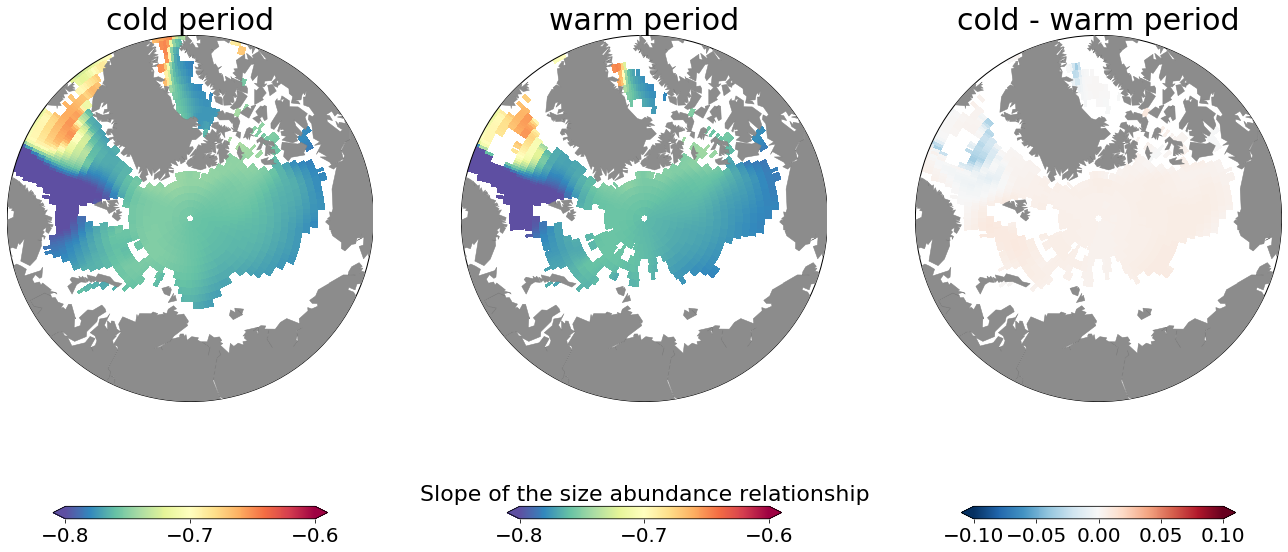

In [20]:
fig = plt.figure(figsize=(18, 10))
lat = mp1C_ds.lat

## Cold Years 
ax = fig.add_subplot(1, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
winter, lon = add_cyclic_point(cold_years.mean(axis=(0,1,2)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,winter,cmap='Spectral_r', vmin = -0.8, vmax = -0.6)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.75, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('cold period', fontsize =30)

## Warm Years
ax = fig.add_subplot(1, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
spring, lon = add_cyclic_point(warm_years.mean(axis=(0,1,2)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,spring,cmap='Spectral_r', vmin = -0.8, vmax = -0.6)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.75, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Slope of the size abundance relationship', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('warm period', fontsize =30)

# Cold - Warm Years 
ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
spring, lon = add_cyclic_point(cold_years.mean(axis=(0,1,2))- warm_years.mean(axis=(0,1,2)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,spring,cmap='RdBu_r', vmin = -0.1, vmax = 0.1)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.75, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('cold - warm period', fontsize =30)

fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/size_abu_slope_surf_warm_vs_cold_50std.png', dpi=600, bbox_inches='tight')

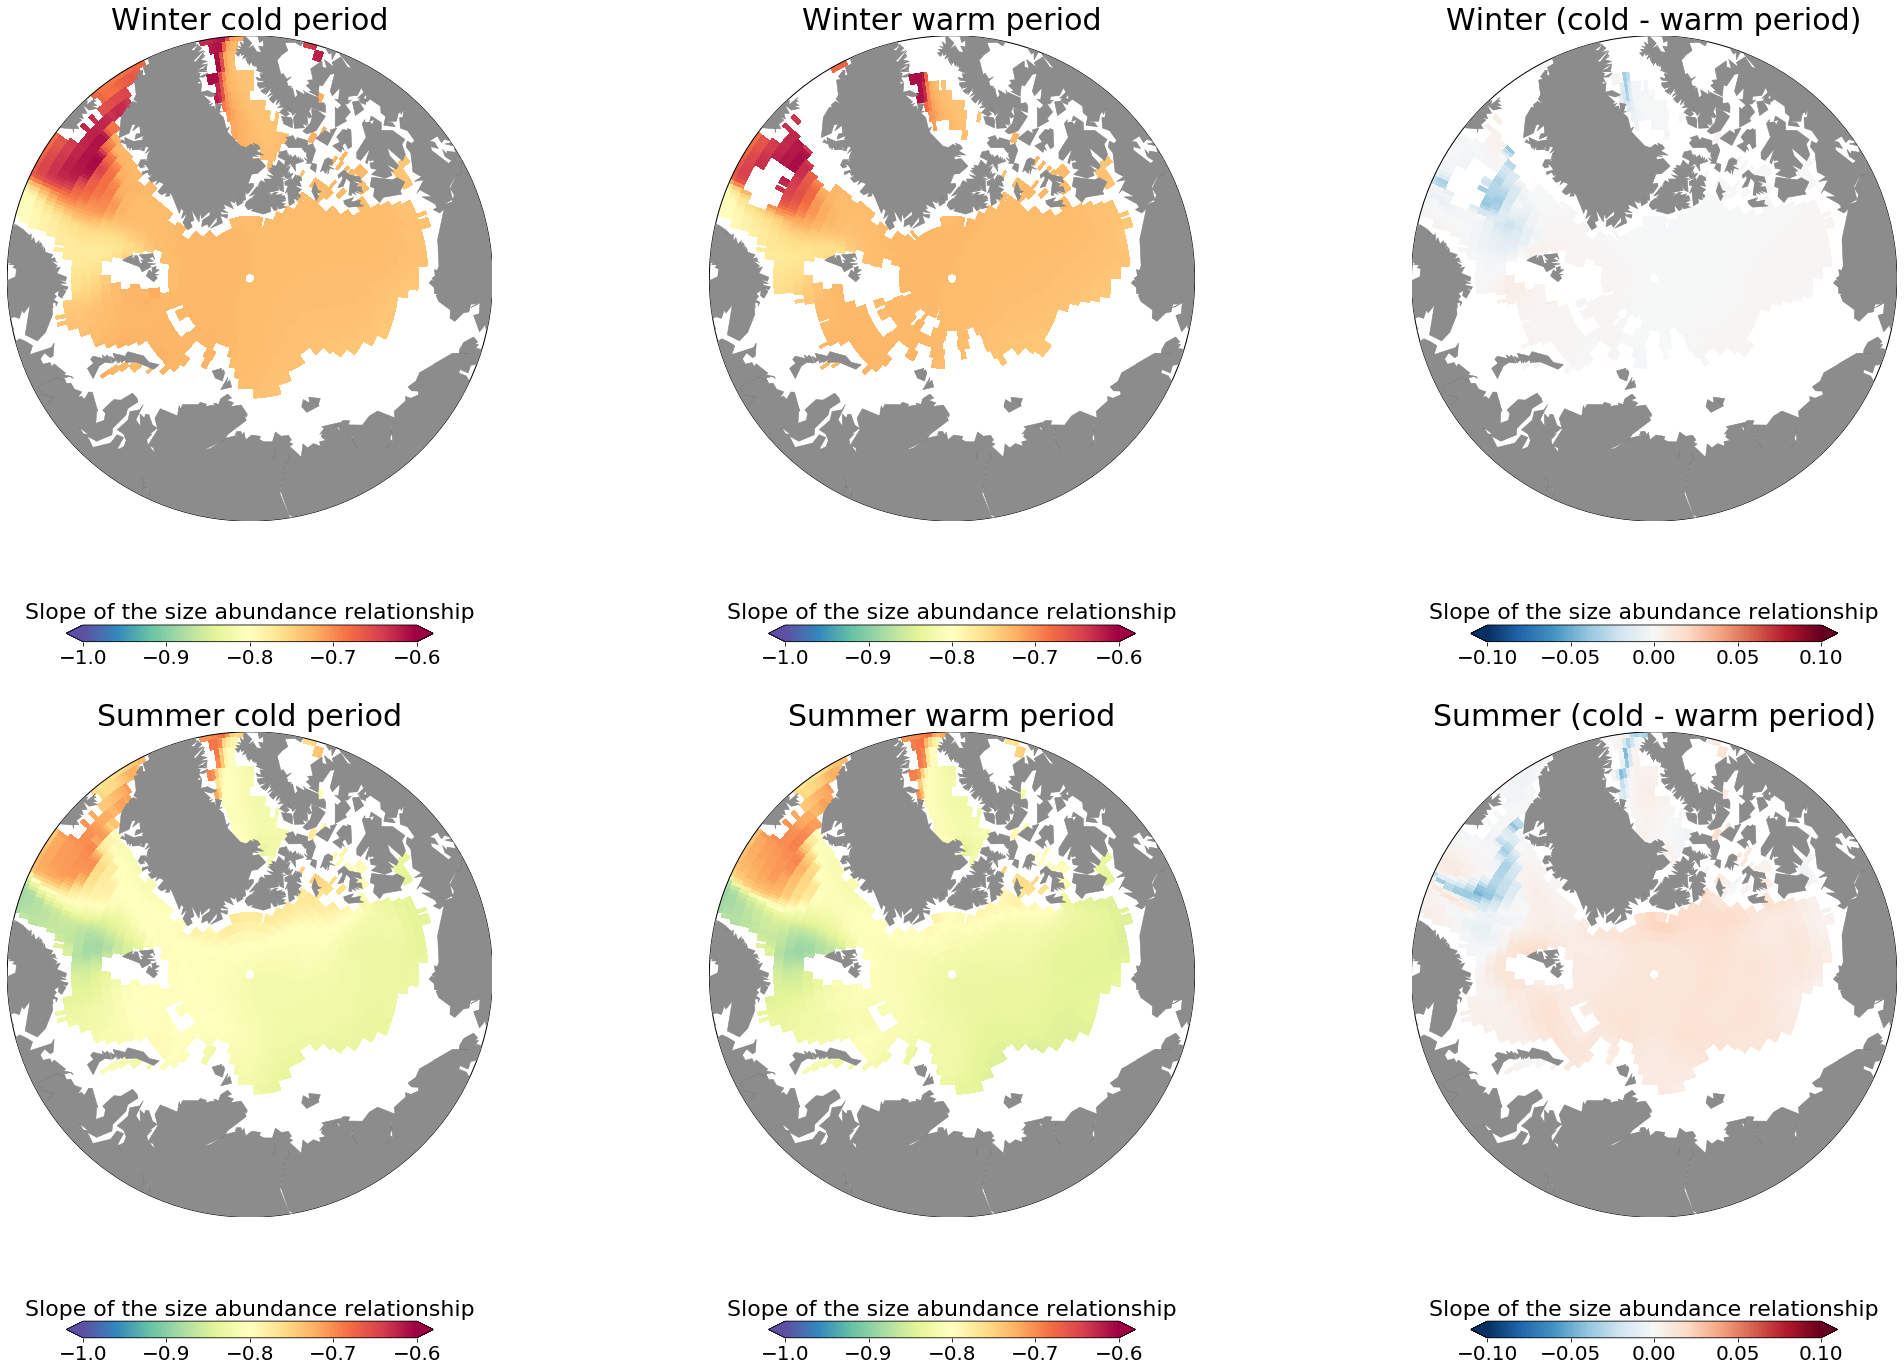

In [21]:
fig = plt.figure(figsize=(30, 20))
lat = mp1C_ds.lat

## WINTER COLD PERIOD
ax = fig.add_subplot(2, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
winter, lon = add_cyclic_point(cold_years[:,:,list(range(2)) + [-1],:,:].mean(axis=(0,1,2)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,winter,cmap='Spectral_r', vmin = -1, vmax = -0.6)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Slope of the size abundance relationship', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Winter cold period', fontsize =30)

## WINTER WARM PERDIOD
ax = fig.add_subplot(2, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
winter, lon = add_cyclic_point(warm_years[:,:,list(range(2)) + [-1],:,:].mean(axis=(0,1,2)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,winter,cmap='Spectral_r', vmin = -1, vmax = -0.6)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Slope of the size abundance relationship', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Winter warm period', fontsize =30)

## WINTER COLD - WARM PERDIOD
ax = fig.add_subplot(2, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
spring, lon = add_cyclic_point(cold_years[:,:,list(range(2)) + [-1],:,:].mean(axis=(0,1,2))- warm_years[:,:,list(range(2)) + [-1],:,:].mean(axis=(0,1,2)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,spring,cmap='RdBu_r', vmin = -0.1, vmax = 0.1)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Slope of the size abundance relationship', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Winter (cold - warm period)', fontsize =30)

## SUMMER COLD PERIOD
ax = fig.add_subplot(2,3, 4)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
summer, lon = add_cyclic_point(cold_years[:,:,5:8,:,:].mean(axis=(0,1,2)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,summer,cmap='Spectral_r', vmin = -1, vmax = -0.6)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Slope of the size abundance relationship', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Summer cold period', fontsize =30)


##SUMMER WARM PERDIOD
ax = fig.add_subplot(2,3, 5)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
summer, lon = add_cyclic_point(warm_years[:,:,5:8,:,:].mean(axis=(0,1,2)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,summer,cmap='Spectral_r', vmin = -1, vmax = -0.6)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Slope of the size abundance relationship', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Summer warm period', fontsize =30)

##SUMMER COLD - WARM PERDIOD
ax = fig.add_subplot(2,3, 6)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
spring, lon = add_cyclic_point(cold_years[:,:,5:8,:,:].mean(axis=(0,1,2))- warm_years[:,:,5:8,:,:].mean(axis=(0,1,2)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,spring,cmap='RdBu_r', vmin = -0.1, vmax = 0.1)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Slope of the size abundance relationship', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Summer (cold - warm period)', fontsize =30)
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/size_abu_slope_surf_warm_vs_cold_seasonal_50std.png', dpi=600, bbox_inches='tight')

## option 2 : Separate from first and second 20-year period, and try to understand makes those large differences?
* 1990-2009
* 1970-1990

In [22]:
cold_years = ypp_surface[22:42,:,:,:,0] # 1962-1973
warm_years = ypp_surface[42:62,:,:,:,0] # 1990-2009

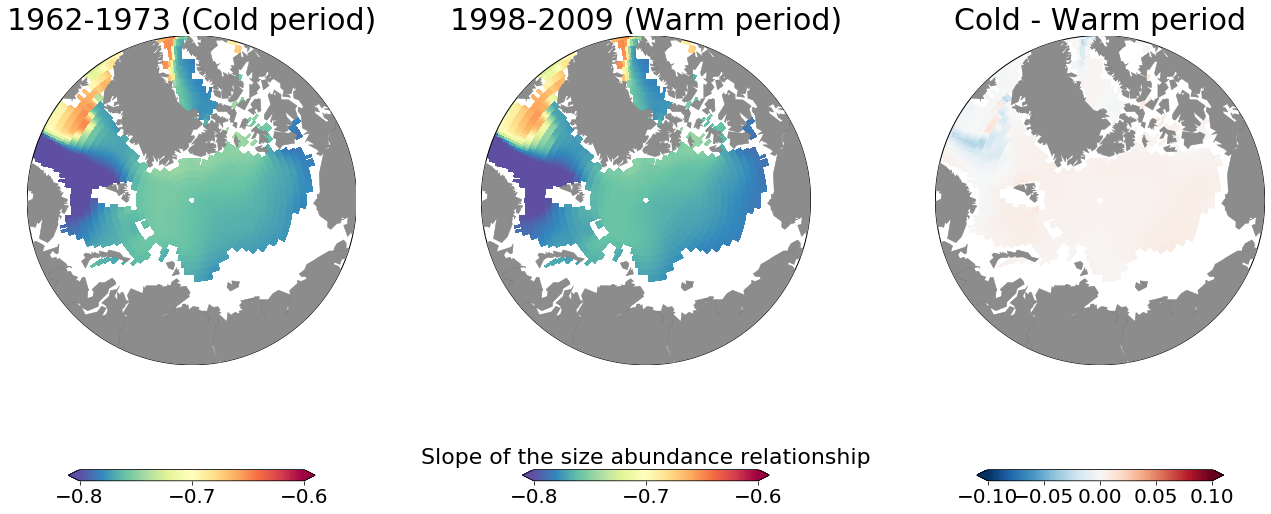

In [23]:
fig = plt.figure(figsize=(18, 10))
lat = mp1C_ds.lat

## Cold Years 
ax = fig.add_subplot(1, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
winter, lon = add_cyclic_point(cold_years.mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,winter,cmap='Spectral_r', vmin = -0.8, vmax = -0.6)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.75, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('1962-1973 (Cold period)', fontsize =30)

## Warm Years
ax = fig.add_subplot(1, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
spring, lon = add_cyclic_point(warm_years.mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,spring,cmap='Spectral_r', vmin = -0.8, vmax = -0.6)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.75, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Slope of the size abundance relationship', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('1998-2009 (Warm period)', fontsize =30)

# Cold - Warm Years 
ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
spring, lon = add_cyclic_point(cold_years.mean(axis=(0,1))- warm_years.mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,spring,cmap='RdBu_r', vmin = -0.1, vmax = 0.1)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.75, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Cold - Warm period', fontsize =30)

fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/size_abu_slope_surf_warm_vs_cold_02.png', dpi=600, bbox_inches='tight')

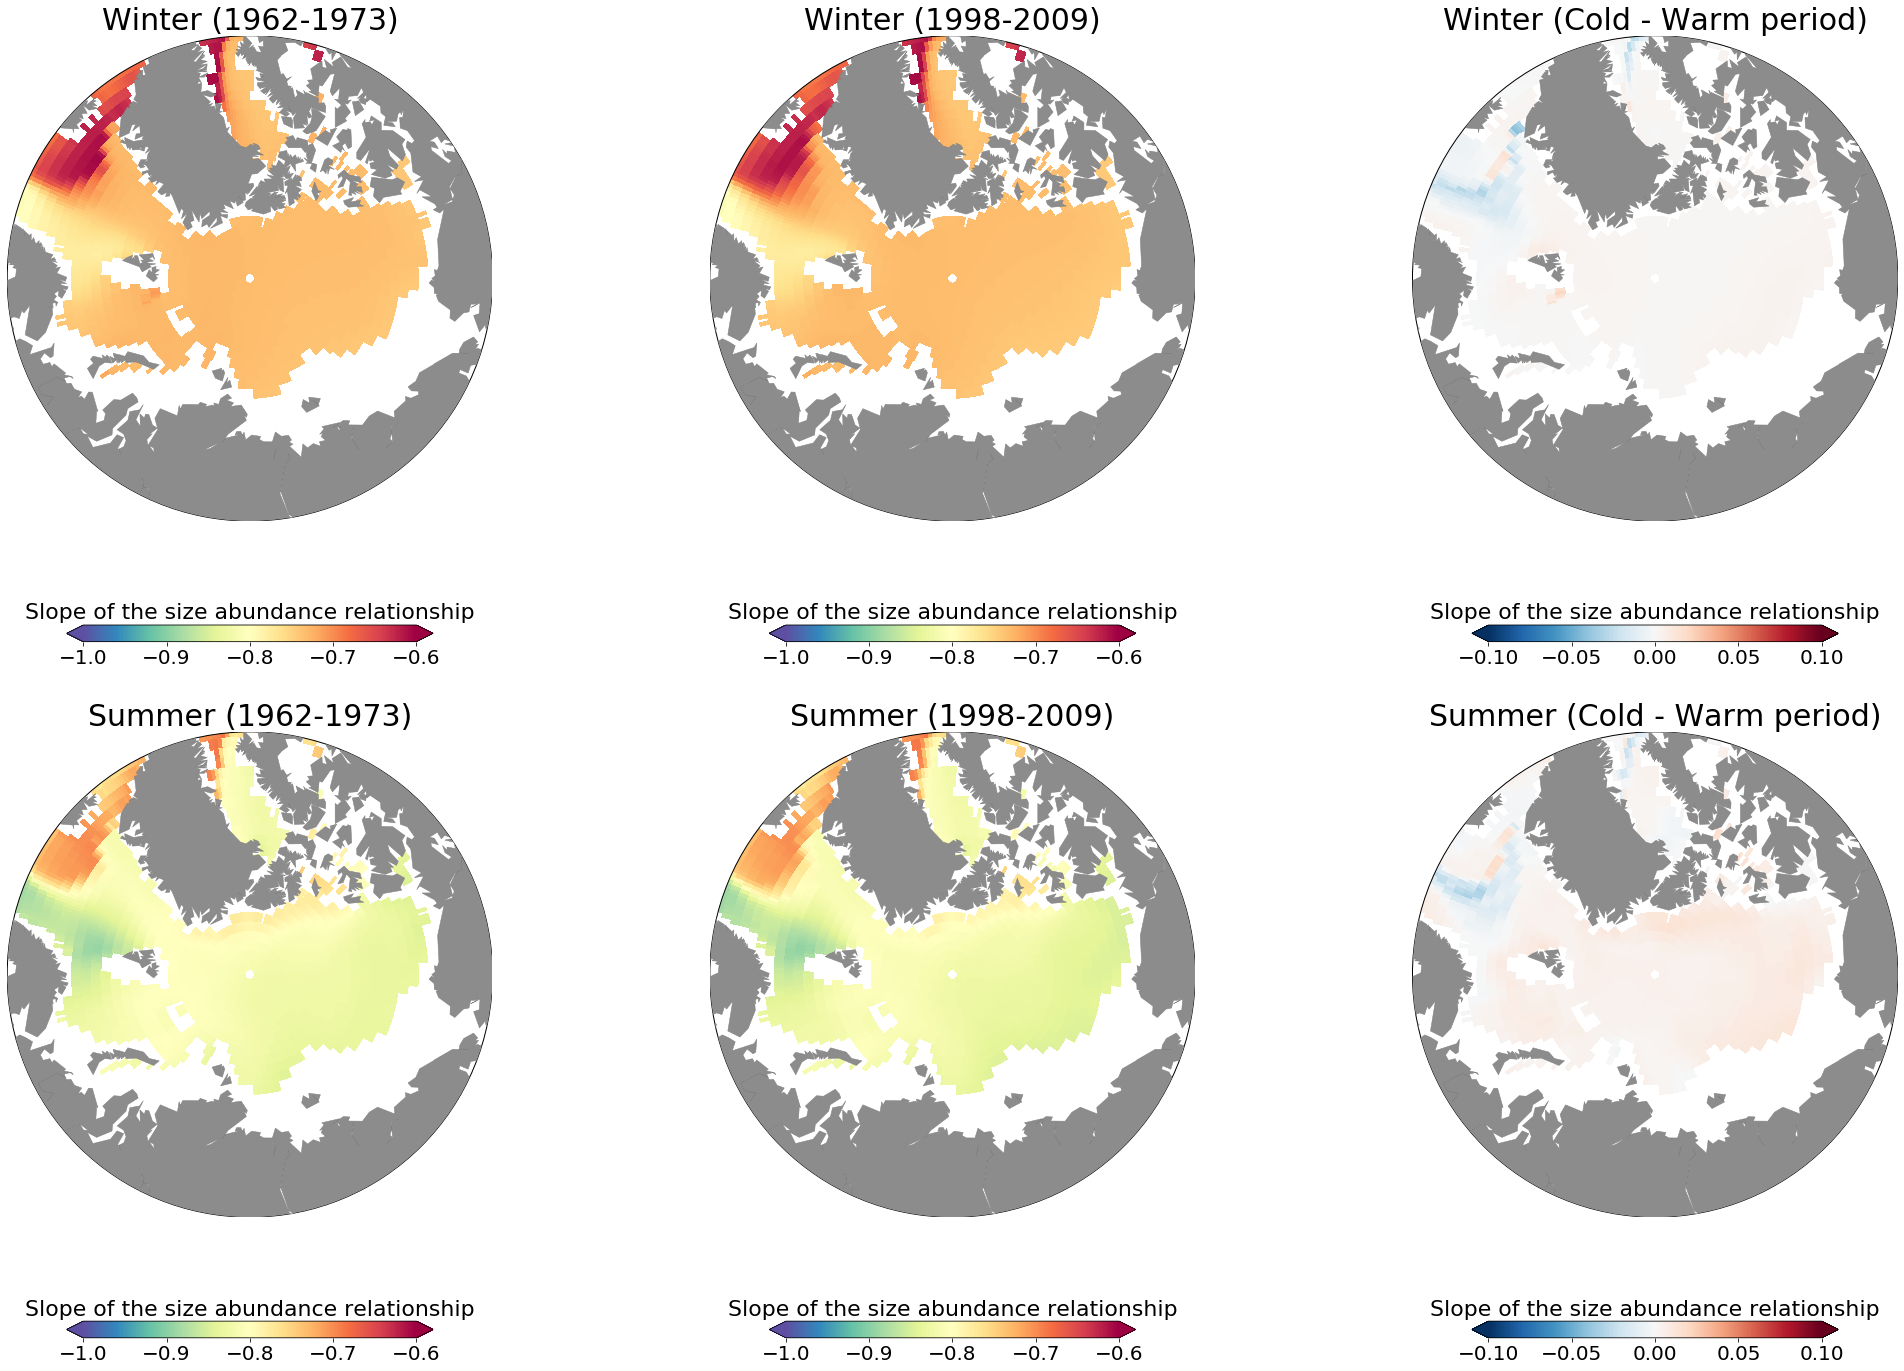

In [24]:
fig = plt.figure(figsize=(30, 20))
lat = mp1C_ds.lat

## WINTER COLD PERIOD
ax = fig.add_subplot(2, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
winter, lon = add_cyclic_point(cold_years[:,list(range(2)) + [-1],:,:].mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,winter,cmap='Spectral_r', vmin = -1, vmax = -0.6)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Slope of the size abundance relationship', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Winter (1962-1973)', fontsize =30)

## WINTER WARM PERDIOD
ax = fig.add_subplot(2, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
winter, lon = add_cyclic_point(warm_years[:,list(range(2)) + [-1],:,:].mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,winter,cmap='Spectral_r', vmin = -1, vmax = -0.6)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Slope of the size abundance relationship', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Winter (1998-2009)', fontsize =30)

## WINTER COLD - WARM PERDIOD
ax = fig.add_subplot(2, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
spring, lon = add_cyclic_point(cold_years[:,list(range(2)) + [-1],:,:].mean(axis=(0,1))- warm_years[:,list(range(2)) + [-1],:,:].mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,spring,cmap='RdBu_r', vmin = -0.1, vmax = 0.1)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Slope of the size abundance relationship', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Winter (Cold - Warm period)', fontsize =30)

## SUMMER COLD PERIOD
ax = fig.add_subplot(2,3, 4)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
summer, lon = add_cyclic_point(cold_years[:,5:8,:,:].mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,summer,cmap='Spectral_r', vmin = -1, vmax = -0.6)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Slope of the size abundance relationship', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Summer (1962-1973)', fontsize =30)


##SUMMER WARM PERDIOD
ax = fig.add_subplot(2,3, 5)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
summer, lon = add_cyclic_point(warm_years[:,5:8,:,:].mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,summer,cmap='Spectral_r', vmin = -1, vmax = -0.6)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Slope of the size abundance relationship', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Summer (1998-2009)', fontsize =30)

##SUMMER COLD - WARM PERDIOD
ax = fig.add_subplot(2,3, 6)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
spring, lon = add_cyclic_point(cold_years[:,5:8,:,:].mean(axis=(0,1))- warm_years[:,5:8,:,:].mean(axis=(0,1)), coord=mp1C_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,mp1C_ds.lat))
cf = m.pcolor(x,y,spring,cmap='RdBu_r', vmin = -0.1, vmax = 0.1)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform', extend = 'both',orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Slope of the size abundance relationship', fontsize=22)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Summer (Cold - Warm period)', fontsize =30)
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/size_abu_slope_surf_warm_vs_cold_seasonal_02.png', dpi=600, bbox_inches='tight')

## Separate Warm and Cold years in every Arctic Region 

In [ ]:
# separate by arcic regions 
temp_ao = np.nanmean(temp_ds_inter[:,:,170:180,:], axis=(2,3))
temp_cs = np.nanmean(temp_ds_inter[:,:,149:170,0:25], axis = (2,3))
temp_bs = np.nanmean(temp_ds_inter[:,:,149:170,25:55], axis = (2,3))
temp_ca = np.nanmean(temp_ds_inter[:,:,149:170,55:110], axis = (2,3))
temp_bb = np.nanmean(temp_ds_inter[:,:,149:170,110:135], axis = (2,3))
temp_ess = np.nanmean(temp_ds_inter[:,:,149:170,325:360], axis = (2,3))
temp_ls = np.nanmean(temp_ds_inter[:,:,149:170,270:325], axis = (2,3))
temp_ns = np.nanmean(temp_ds_inter[:,:,149:170,155:205], axis = (2,3))
temp_bts =np.nanmean(temp_ds_inter[:,:,149:170,205:233], axis = (2,3))
temp_ks = np.nanmean(temp_ds_inter[:,:,149:170,233:270], axis = (2,3))

# Calculate anomalies
temp_ao_anom = temp_ao-np.nanmean(temp_ao,axis=0)
temp_cs_anom = temp_cs-np.nanmean(temp_cs,axis=0)
temp_bs_anom = temp_bs-np.nanmean(temp_bs,axis=0)
temp_ca_anom = temp_ca-np.nanmean(temp_ca,axis=0)
temp_bb_anom = temp_bb-np.nanmean(temp_bb,axis=0)
temp_ess_anom = temp_ess-np.nanmean(temp_ess,axis=0)
temp_ls_anom = temp_ls-np.nanmean(temp_ls,axis=0)
temp_ns_anom = temp_ns-np.nanmean(temp_ns,axis=0)
temp_bts_anom =temp_bts-np.nanmean(temp_bts,axis=0)
temp_ks_anom = temp_ks-np.nanmean(temp_ks,axis=0)

# This is the error on the observations
err_ao = np.nanstd(temp_ao_anom,axis=1)
err_cs = np.nanstd(temp_cs_anom,axis=1)
err_bs = np.nanstd(temp_bs_anom,axis=1)
err_ca = np.nanstd(temp_ca_anom,axis=1)
err_bb = np.nanstd(temp_bb_anom,axis=1)
err_ess = np.nanstd(temp_ess_anom,axis=1)
err_ls = np.nanstd(temp_ls_anom,axis=1)
err_ns = np.nanstd(temp_ns_anom,axis=1)
err_bts = np.nanstd(temp_bts_anom,axis=1)
err_ks = np.nanstd(temp_ks_anom,axis=1)

# Find cold years
cold_years_ao = np.where(np.nanmean(temp_ao_anom,axis=1) < 0)
cold_years_cs = np.where(np.nanmean(temp_cs_anom,axis=1) < 0)
cold_years_bs = np.where(np.nanmean(temp_bs_anom,axis=1) < 0)
cold_years_ca = np.where(np.nanmean(temp_ca_anom,axis=1) < 0)
cold_years_bb = np.where(np.nanmean(temp_bb_anom,axis=1) < 0)
cold_years_ess = np.where(np.nanmean(temp_ess_anom,axis=1) < 0)
cold_years_ls = np.where(np.nanmean(temp_ls_anom,axis=1) < 0)
cold_years_ns = np.where(np.nanmean(temp_ns_anom,axis=1) < 0)
cold_years_bts = np.where(np.nanmean(temp_bts_anom,axis=1) < 0)
cold_years_ks = np.where(np.nanmean(temp_ks_anom,axis=1) < 0)

# Find warm years 
warm_years_ao = np.where(np.nanmean(temp_ao_anom,axis=1) > 0)
warm_years_cs = np.where(np.nanmean(temp_cs_anom,axis=1) > 0)
warm_years_bs = np.where(np.nanmean(temp_bs_anom,axis=1) > 0)
warm_years_ca = np.where(np.nanmean(temp_ca_anom,axis=1) > 0)
warm_years_bb = np.where(np.nanmean(temp_bb_anom,axis=1) > 0)
warm_years_ess = np.where(np.nanmean(temp_ess_anom,axis=1) > 0)
warm_years_ls = np.where(np.nanmean(temp_ls_anom,axis=1) > 0)
warm_years_ns = np.where(np.nanmean(temp_ns_anom,axis=1) > 0)
warm_years_bts = np.where(np.nanmean(temp_bts_anom,axis=1) > 0)
warm_years_ks = np.where(np.nanmean(temp_ks_anom,axis=1) > 0)